In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

results = pd.read_parquet("./sampling_scaling_rtt.gzip")

# only look at the empirical-high timing model (ground truth)
results = results[results["timing_model"] == "empirical-high"].copy()
results["timing_model"] = results["timing_model"].cat.remove_unused_categories()


def _classify_sampling(s: str) -> str:
    ssplit = s.split("-")
    if len(ssplit) > 1:
        if ssplit[0] == "adaptive":
            if ssplit[1] == "power":
                return "adaptive-energy"
            else:
                return "adaptive-ttf"
        return ssplit[0]
    else:
        return "reference"


results["sampling_class"] = (
    results["sampling_scheme"]
    .apply(_classify_sampling)
    .astype(pd.CategoricalDtype(["adaptive-energy", "adaptive-ttf", "reference", "periodic", "hold"]))
)

included_schemes = ['greedy',
 'ideal',
 'adaptive-power-empirical',
 'adaptive-power-empirical-low',
 'adaptive-power-empirical-high',
 'adaptive-power-theoretical-exgaussian',
 'adaptive-power-theoretical-exgaussian-low',
 'adaptive-power-theoretical-exgaussian-high',
 'adaptive-power-fitted-naive-exgaussian',
 'periodic-0.1s',
 'periodic-0.2s',
 'periodic-0.5s',
 'periodic-1.0s',
 'hold-3.0s',
 'hold-5.0s',
 'hold-7.0s']

results = results[np.isin(results["sampling_scheme"], included_schemes)]
results["sampling_scheme"] = results["sampling_scheme"].astype(pd.CategoricalDtype(included_schemes, ordered=True))
results["success_sample_instant"] = results["execution_time"] + results["wait_time"]

results

,rtt,step,previous_ttf,execution_time,step_duration,ttf,wait_time,samples,cumulative_duration,cumulative_samples,...,energy,cumulative_energy,comm_time,idle_time,comm_energy,idle_energy,timing_model,sampling_scheme,sampling_class,success_sample_instant
0,2.0,1,2.000000,4.196099,9.058145,4.862046,2.862046,1,9.058145,1,...,0.186872,0.186872,1.7,7.358145,0.0765,0.110372,empirical-high,adaptive-power-empirical-high,adaptive-energy,7.058145
1,2.0,2,4.862046,3.207260,9.226183,6.018923,4.018923,1,18.284328,2,...,0.189393,0.376265,1.7,7.526183,0.0765,0.112893,empirical-high,adaptive-power-empirical-high,adaptive-energy,7.226183
2,2.0,3,6.018923,3.535052,9.226183,5.691131,3.691131,1,27.510511,3,...,0.189393,0.565658,1.7,7.526183,0.0765,0.112893,empirical-high,adaptive-power-empirical-high,adaptive-energy,7.226183
3,2.0,4,5.691131,2.462852,9.226183,6.763331,4.763331,1,36.736695,4,...,0.189393,0.755050,1.7,7.526183,0.0765,0.112893,empirical-high,adaptive-power-empirical-high,adaptive-energy,7.226183
4,2.0,5,6.763331,4.603787,9.226183,4.622396,2.622396,1,45.962878,5,...,0.189393,0.944443,1.7,7.526183,0.0765,0.112893,empirical-high,adaptive-power-empirical-high,adaptive-energy,7.226183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151995,4.5,116,6.194516,3.338850,10.000000,6.661150,2.161150,2,1596.500000,329,...,0.402000,65.401500,8.4,1.600000,0.3780,0.024000,empirical-high,periodic-1.0s,periodic,5.500000
1151996,4.5,117,6.661150,2.533906,10.000000,7.466094,2.966094,2,1606.500000,331,...,0.402000,65.803500,8.4,1.600000,0.3780,0.024000,empirical-high,periodic-1.0s,periodic,5.500000
1151997,4.5,118,7.466094,8.927808,14.500000,5.572192,1.072192,3,1621.000000,334,...,0.595500,66.399000,12.6,1.900000,0.5670,0.028500,empirical-high,periodic-1.0s,periodic,10.000000
1151998,4.5,119,5.572192,5.522418,14.500000,8.977582,4.477582,3,1635.500000,337,...,0.595500,66.994500,12.6,1.900000,0.5670,0.028500,empirical-high,periodic-1.0s,periodic,10.000000


In [2]:
power_consts = {
    # "comm": 0.045,
    "comm": 0.045,
    "idle": 0.015
}  # Watts

mean_power = (
    results.groupby(["sampling_class", "sampling_scheme", "rtt", "repetition"], observed=True)
    [["samples", "idle_time", "comm_time", "step_duration"]]
    .sum()
    .reset_index()
    .copy()
)
mean_power["comm_time"] = mean_power["samples"] * (mean_power["rtt"] - 0.3)
mean_power["comm_energy"] = mean_power["comm_time"] * power_consts["comm"]
mean_power["idle_time"] = mean_power["step_duration"] - mean_power["comm_time"]
mean_power["idle_energy"] = mean_power["idle_time"] * power_consts["idle"]

mean_power["total_energy"] = mean_power["idle_energy"] + mean_power["comm_energy"]
mean_power["power"] = mean_power["total_energy"] / mean_power["step_duration"]
mean_power

,sampling_class,sampling_scheme,rtt,repetition,samples,idle_time,comm_time,step_duration,comm_energy,idle_energy,total_energy,power
0,adaptive-energy,adaptive-power-empirical,0.5,1,351,783.139703,70.2,853.339703,3.1590,11.747096,14.906096,0.017468
1,adaptive-energy,adaptive-power-empirical,0.5,2,344,786.209203,68.8,855.009203,3.0960,11.793138,14.889138,0.017414
2,adaptive-energy,adaptive-power-empirical,0.5,3,360,803.521822,72.0,875.521822,3.2400,12.052827,15.292827,0.017467
3,adaptive-energy,adaptive-power-empirical,0.5,4,352,785.264521,70.4,855.664521,3.1680,11.778968,14.946968,0.017468
4,adaptive-energy,adaptive-power-empirical,0.5,5,358,802.446494,71.6,874.046494,3.2220,12.036697,15.258697,0.017458
...,...,...,...,...,...,...,...,...,...,...,...,...
9595,periodic,periodic-1.0s,5.0,56,309,212.700000,1452.3,1665.000000,65.3535,3.190500,68.544000,0.041168
9596,periodic,periodic-1.0s,5.0,57,324,217.200000,1522.8,1740.000000,68.5260,3.258000,71.784000,0.041255
9597,periodic,periodic-1.0s,5.0,58,341,222.300000,1602.7,1825.000000,72.1215,3.334500,75.456000,0.041346
9598,periodic,periodic-1.0s,5.0,59,324,217.200000,1522.8,1740.000000,68.5260,3.258000,71.784000,0.041255


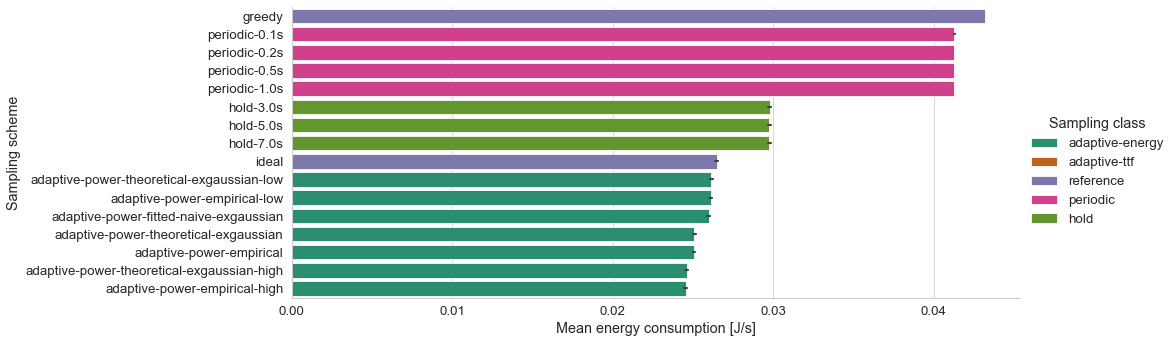

count      mean  \
sampling_class  sampling_scheme                                               
reference       greedy                                       60.0  0.043200   
periodic        periodic-0.1s                                60.0  0.041294   
                periodic-0.2s                                60.0  0.041292   
                periodic-0.5s                                60.0  0.041291   
                periodic-1.0s                                60.0  0.041286   
hold            hold-3.0s                                    60.0  0.029796   
                hold-5.0s                                    60.0  0.029775   
                hold-7.0s                                    60.0  0.029761   
reference       ideal                                        60.0  0.026489   
adaptive-energy adaptive-power-theoretical-exgaussian-low    60.0  0.026140   
                adaptive-power-empirical-low                 60.0  0.026121   
                adaptive-power-fitted-naive-exgaussian       60.0  0.025994   
                adaptive-power-theoretical-exgaussian        60.0  0.025092   
                adaptive-power-empirical                     60.0  0.025068   
                adaptive-power-theoretical-exgaussian-high   60.0  0.024615   
                adaptive-power-empirical-high                60.0  0.024546   

                                                                     std  \
sampling_class  sampling_scheme                                            
reference       greedy                                      1.091543e-17   
periodic        periodic-0.1s                               5.984950e-05   
                periodic-0.2s                               5.105607e-05   
                periodic-0.5s                               4.503401e-05   
                periodic-1.0s                               5.388733e-05   
hold            hold-3.0s                                   3.560072e-04   
                hold-5.0s                                   3.621975e-04   
                hold-7.0s                                   4.006350e-04   
reference       ideal                                       4.021966e-04   
adaptive-energy adaptive-power-theoretical-exgaussian-low   3.990872e-04   
                adaptive-power-empirical-low                3.553771e-04   
                adaptive-power-fitted-naive-exgaussian      3.392912e-04   
                adaptive-power-theoretical-exgaussian       3.013396e-04   
                adaptive-power-empirical                    2.938973e-04   
                adaptive-power-theoretical-exgaussian-high  2.923939e-04   
                adaptive-power-empirical-high               2.988980e-04   

                                                                 min  \
sampling_class  sampling_scheme                                        
reference       greedy                                      0.043200   
periodic        periodic-0.1s                               0.041149   
                periodic-0.2s                               0.041204   
                periodic-0.5s                               0.041198   
                periodic-1.0s                               0.041168   
hold            hold-3.0s                                   0.029100   
                hold-5.0s                                   0.028800   
                hold-7.0s                                   0.028930   
reference       ideal                                       0.025595   
adaptive-energy adaptive-power-theoretical-exgaussian-low   0.025066   
                adaptive-power-empirical-low                0.025437   
                adaptive-power-fitted-naive-exgaussian      0.025327   
                adaptive-power-theoretical-exgaussian       0.024538   
                adaptive-power-empirical                    0.024360   
                adaptive-power-theoretical-exgaussian-high  0.024070   
                adaptive-power-empirical-hig

In [58]:
power_max_rtt = mean_power[mean_power["rtt"] == mean_power["rtt"].max()]
mean_power_max_rtt = (
    power_max_rtt
    .groupby(["sampling_class", "sampling_scheme"], observed=True)
    ["power"]
    .describe()
    .sort_values("mean", ascending=False)
)

fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=power_max_rtt,
    x="power",
    y="sampling_scheme",
    order=mean_power_max_rtt.index.get_level_values(1),
    hue="sampling_class",
    aspect=3,
    dodge=False,
)
fg.set_axis_labels("Mean energy consumption [J/s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

mean_power_max_rtt

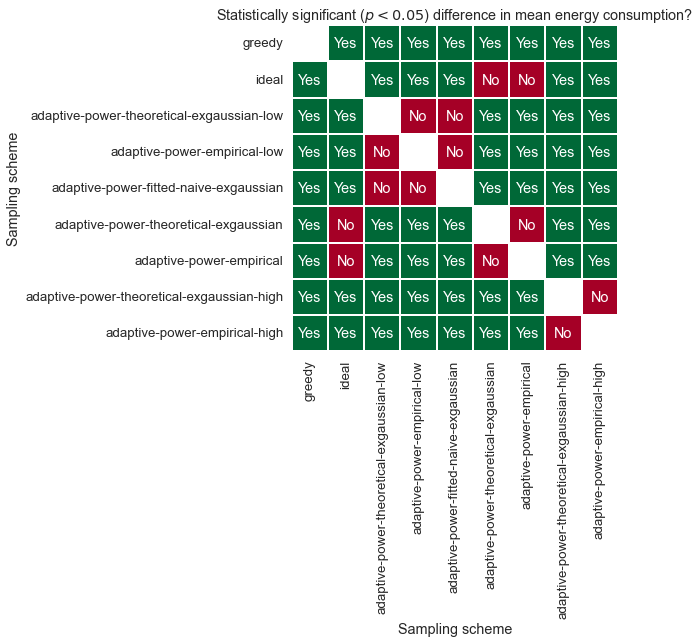

In [90]:
import scipy.stats as stats
import itertools as it

relevant_schemes = mean_power_max_rtt.loc[["reference", "adaptive-energy"], :].sort_values("mean", ascending=False).index.get_level_values(1)

p_values = pd.DataFrame(index=relevant_schemes, columns=relevant_schemes, dtype=float)
for row, col in it.product(p_values.index, p_values.columns):
    if row == col:
        continue
    t_stat, p_val = stats.ttest_ind(
        mean_power.loc[mean_power["sampling_scheme"] == row, "power"].to_numpy(),
        mean_power.loc[mean_power["sampling_scheme"] == col, "power"].to_numpy(),
        alternative="two-sided",
        # null-hypothesis is that energies have the same mean and that the observed difference is just random
    )
    p_values.at[row, col] = p_val

significant = p_values < 0.05
significant[p_values.isna()] = np.NaN
for c in significant.columns:
    significant[c] = significant[c].astype(float)

fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(
    significant,
    square=True,
    annot=significant.applymap(lambda e: "Yes" if e > 0.5 else "No"),
    fmt="",
    # center=0.05,
    cbar=False,
    cmap="RdYlGn",
    linewidths=2,
    ax=ax,
)
ax.set_title("Statistically significant ($p < 0.05$) difference in mean energy consumption?")
ax.set_xlabel("Sampling scheme")
ax.set_ylabel("Sampling scheme")
plt.show()

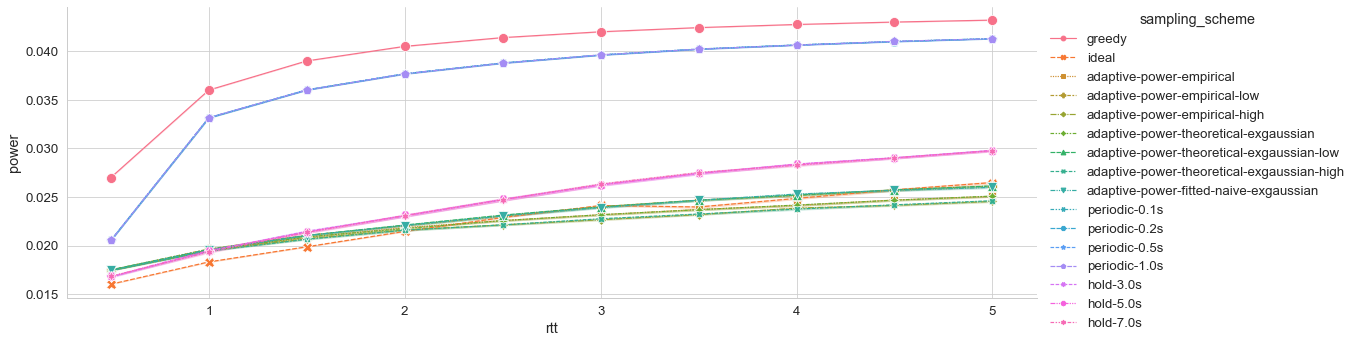

In [6]:
fg = sns.relplot(
    kind="line",
    data=mean_power,
    x="rtt",
    y="power",
    style="sampling_scheme",
    hue="sampling_scheme",
    markers=True,
    aspect=3,
    markersize=10,
)
plt.show()

In [7]:
results_per_rep = (
    results
    .groupby(["timing_model", "sampling_scheme", "sampling_class", "rtt", "repetition"], observed=True)
    [["execution_time", "step_duration", "ttf", "wait_time", "samples", "energy", "idle_energy", "comm_energy", "idle_time", "comm_time", "success_sample_instant"]]
    .mean()
    .reset_index()
)
results_per_rep

,timing_model,sampling_scheme,sampling_class,rtt,repetition,execution_time,step_duration,ttf,wait_time,samples,energy,idle_energy,comm_energy,idle_time,comm_time,success_sample_instant
0,empirical-high,greedy,reference,0.5,1,5.398337,6.112500,0.714163,0.214163,12.225000,0.165038,0.055012,0.110025,3.6675,2.445000,5.612500
1,empirical-high,greedy,reference,0.5,2,5.239142,5.954167,0.715025,0.215025,11.908333,0.160763,0.053587,0.107175,3.5725,2.381667,5.454167
2,empirical-high,greedy,reference,0.5,3,5.543154,6.295833,0.752680,0.252680,12.591667,0.169987,0.056662,0.113325,3.7775,2.518333,5.795833
3,empirical-high,greedy,reference,0.5,4,5.663351,6.400000,0.736649,0.236649,12.800000,0.172800,0.057600,0.115200,3.8400,2.560000,5.900000
4,empirical-high,greedy,reference,0.5,5,5.369317,6.104167,0.734850,0.234850,12.208333,0.164813,0.054937,0.109875,3.6625,2.441667,5.604167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,empirical-high,hold-7.0s,hold,5.0,56,6.742787,14.333333,7.590546,2.590546,1.466667,0.421800,0.111600,0.310200,7.4400,6.893333,9.333333
9596,empirical-high,hold-7.0s,hold,5.0,57,6.963642,14.375000,7.411358,2.411358,1.475000,0.423600,0.111638,0.311962,7.4425,6.932500,9.375000
9597,empirical-high,hold-7.0s,hold,5.0,58,7.066357,14.750000,7.683643,2.683643,1.550000,0.439800,0.111975,0.327825,7.4650,7.285000,9.750000
9598,empirical-high,hold-7.0s,hold,5.0,59,7.033664,14.541667,7.508002,2.508002,1.508333,0.430800,0.111787,0.319013,7.4525,7.089167,9.541667


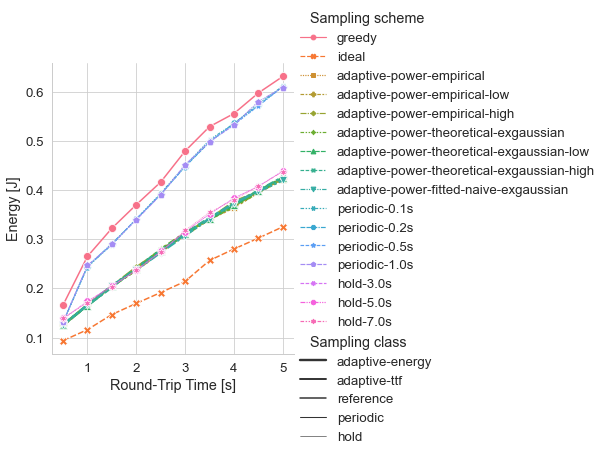

In [8]:
fg = sns.relplot(
    kind="line",
    errorbar=None,
    data=results_per_rep.rename(columns={"sampling_scheme": "Sampling scheme", "sampling_class": "Sampling class"}),
    x="rtt",
    y="energy",
    hue="Sampling scheme",
    style="Sampling scheme",
    size="Sampling class",
    markers=True,
    aspect=1,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Energy [J]")
# fg.legend.set_title("Sampling Scheme")
plt.show()

In [9]:
energy_at_max_rtt = (
    results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()]
    .groupby("sampling_scheme")
    ["energy"]
    .mean()
    .sort_values()
)
energy_at_max_rtt

sampling_scheme
ideal                                         0.325307
adaptive-power-fitted-naive-exgaussian        0.419891
adaptive-power-empirical                      0.421543
adaptive-power-theoretical-exgaussian         0.422777
adaptive-power-empirical-high                 0.423392
adaptive-power-empirical-low                  0.424290
adaptive-power-theoretical-exgaussian-low     0.425068
adaptive-power-theoretical-exgaussian-high    0.426837
hold-7.0s                                     0.437730
hold-5.0s                                     0.438240
hold-3.0s                                     0.439260
periodic-1.0s                                 0.608730
periodic-0.5s                                 0.610320
periodic-0.2s                                 0.610590
periodic-0.1s                                 0.611610
greedy                                        0.631380
Name: energy, dtype: float64

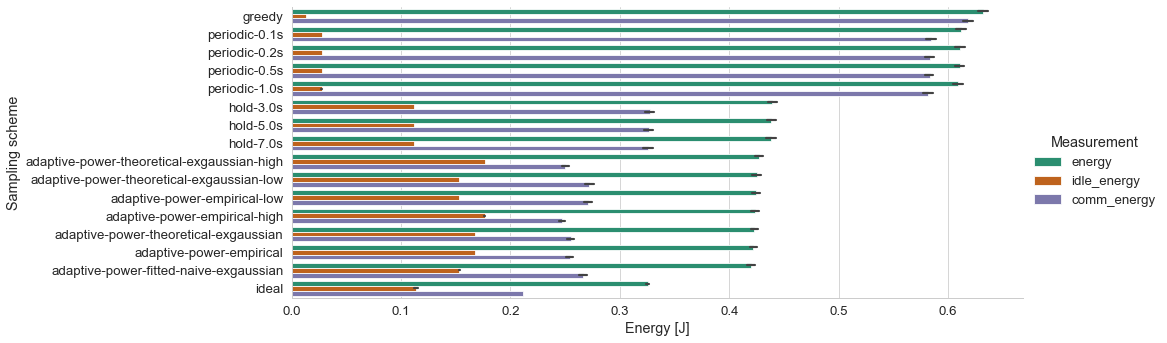

In [10]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=(
        results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()]
        [["sampling_scheme", "energy", "idle_energy", "comm_energy"]]
        .set_index("sampling_scheme")
        .stack()
        .reset_index()
        .rename(columns={"level_1": "energy", 0: "value"})
    ),
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="value",
    # join=False,
    hue="energy",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=True,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Measurement")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.10588235294117647, 0.6196078431372549, 0.4666666666666667)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.8509803921568627, 0.37254901960784315, 0.00784313725490196)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.4588235294117647, 0.4392156862745098, 0.7019607843137254)) for an unfilled marker ('+').  Matplotlib is ignoring

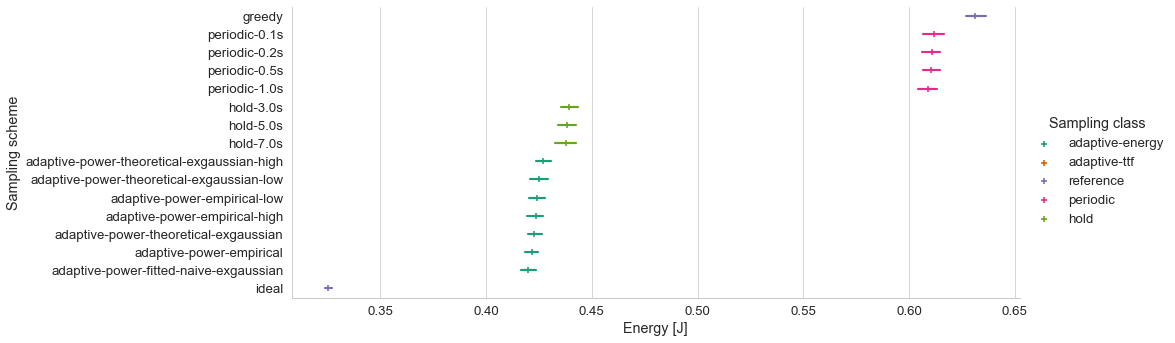

In [11]:
fg = sns.catplot(
    kind="point",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="energy",
    join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    markers="+",
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

test if difference between mean energies at max rtt is statistically significant!
null hypothesis is that all sampling schemes have the same mean

In [12]:
import scipy.stats as stats

# import itertools as it

energies = (
    results_per_rep
    .loc[(results_per_rep["rtt"] == results_per_rep["rtt"].max())]
    .copy()
)

p_values = pd.DataFrame(index=included_schemes, columns=included_schemes, dtype=float)
cols = set(included_schemes)
last_row = len(included_schemes)
for row in included_schemes:
    for col in cols:
        if row == col:
            continue
        t_stat, p_val = stats.ttest_ind(
            energies.loc[energies["sampling_scheme"] == row, "energy"].to_numpy(),
            energies.loc[energies["sampling_scheme"] == col, "energy"].to_numpy(),
            alternative="two-sided",
            # null-hypothesis is that energies have the same mean and that the observed difference is just random
        )
        p_values.at[row, col] = p_val

    # cols.remove(row)
p_values.style.format(lambda e: "p < 0.05" if e < 0.05 else "Not significant")

,greedy,ideal,adaptive-power-empirical,adaptive-power-empirical-low,adaptive-power-empirical-high,adaptive-power-theoretical-exgaussian,adaptive-power-theoretical-exgaussian-low,adaptive-power-theoretical-exgaussian-high,adaptive-power-fitted-naive-exgaussian,periodic-0.1s,periodic-0.2s,periodic-0.5s,periodic-1.0s,hold-3.0s,hold-5.0s,hold-7.0s
greedy,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
ideal,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-empirical,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-empirical-low,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-empirical-high,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-theoretical-exgaussian,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-theoretical-exgaussian-low,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-theoretical-exgaussian-high,p < 0.05,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-fitted-naive-exgaussian,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,Not significant,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
periodic-0.1s,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05


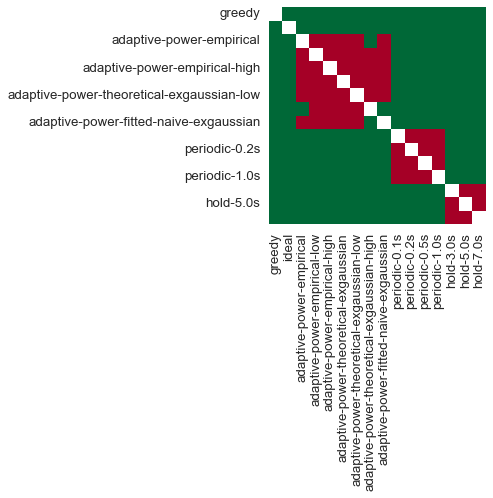

In [13]:
significant = p_values < 0.05
significant[p_values.isna()] = np.NaN
for c in significant.columns:
    significant[c] = significant[c].astype(float)

ax = sns.heatmap(
    significant,
    square=True,
    # annot=True,
    # center=0.05,
    cbar=False,
    cmap="RdYlGn",
)
plt.show()


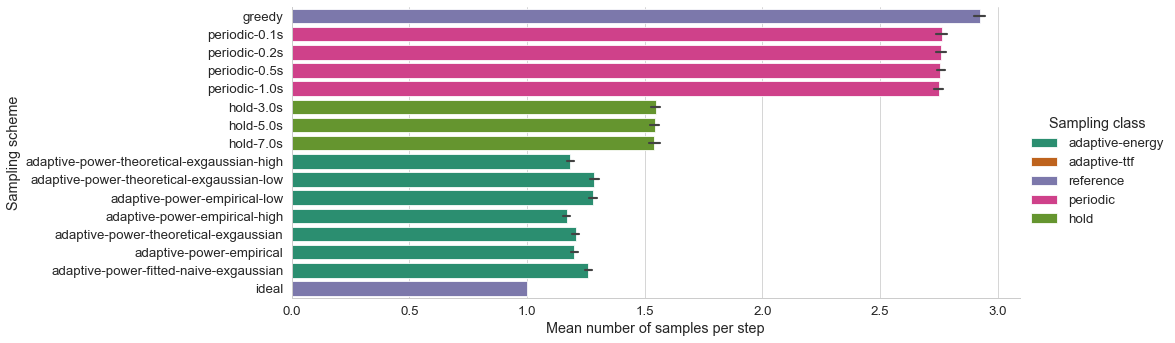

In [14]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="samples",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean number of samples per step", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

In [15]:
(
    results[results["rtt"] == results["rtt"].max()]
    .groupby("sampling_scheme")
    ["samples"]
    .value_counts()
    .loc[pd.IndexSlice["adaptive-power-empirical-high"], :]
    .to_frame()
    .rename(columns={"samples": "counts"})
    .reset_index()
    .sort_values("samples")
)

,samples,counts
0,1,6510
1,2,464
2,3,96
5,4,4
3,5,87
4,6,39


In [16]:
(
    results[results["rtt"] == results["rtt"].max()]
    .groupby(["sampling_scheme", "samples"], observed=True)
    ["wait_time"]
    .describe()
    .loc["adaptive-power-empirical-high", :]
)

,count,mean,std,min,25%,50%,75%,max
samples,,,,,,,,
1,6510.0,5.093916,2.216799,0.121705,3.625887,5.229639,7.036070,10.968521
2,464.0,4.819556,2.063014,0.005345,3.772550,5.654586,6.435820,6.601627
3,96.0,3.742273,0.292732,2.079768,3.601863,3.601863,3.981555,4.520117
4,4.0,4.006518,0.239423,3.799172,3.799172,4.006518,4.213864,4.213864
5,87.0,1.938836,0.148416,1.817776,1.817776,1.817776,2.118697,2.118697
6,39.0,4.621723,0.246300,3.123018,4.661162,4.661162,4.661162,4.661162


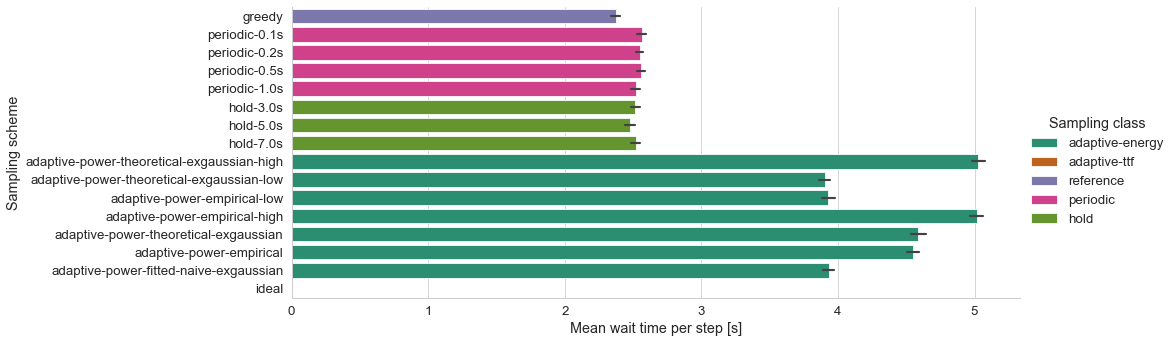

In [17]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="wait_time",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean wait time per step [s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

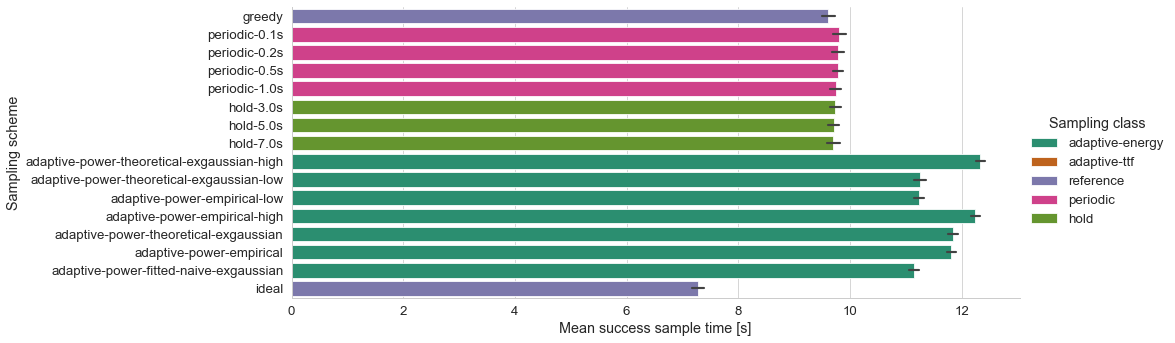

In [18]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="success_sample_instant",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean success sample time [s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

In [19]:
energies_maxrtt = results_per_rep.loc[(results_per_rep["rtt"] == results_per_rep["rtt"].max())].groupby(
    ["sampling_class", "sampling_scheme"])["energy"].describe(percentiles=[])
energies_maxrtt["var"] = np.square(energies_maxrtt["std"])
energies_maxrtt

count      mean  \
sampling_class  sampling_scheme                                               
adaptive-energy adaptive-power-empirical                     60.0  0.421543   
                adaptive-power-empirical-low                 60.0  0.424290   
                adaptive-power-empirical-high                60.0  0.423392   
                adaptive-power-theoretical-exgaussian        60.0  0.422777   
                adaptive-power-theoretical-exgaussian-low    60.0  0.425068   
                adaptive-power-theoretical-exgaussian-high   60.0  0.426837   
                adaptive-power-fitted-naive-exgaussian       60.0  0.419891   
reference       greedy                                       60.0  0.631380   
                ideal                                        60.0  0.325307   
periodic        periodic-0.1s                                60.0  0.611610   
                periodic-0.2s                                60.0  0.610590   
                periodic-0.5s                                60.0  0.610320   
                periodic-1.0s                                60.0  0.608730   
hold            hold-3.0s                                    60.0  0.439260   
                hold-5.0s                                    60.0  0.438240   
                hold-7.0s                                    60.0  0.437730   

                                                                 std  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.013060   
                adaptive-power-empirical-low                0.015367   
                adaptive-power-empirical-high               0.013710   
                adaptive-power-theoretical-exgaussian       0.013415   
                adaptive-power-theoretical-exgaussian-low   0.017131   
                adaptive-power-theoretical-exgaussian-high  0.013530   
                adaptive-power-fitted-naive-exgaussian      0.014576   
reference       greedy                                      0.019208   
                ideal                                       0.006470   
periodic        periodic-0.1s                               0.020252   
                periodic-0.2s                               0.017297   
                periodic-0.5s                               0.015197   
                periodic-1.0s                               0.017849   
hold            hold-3.0s                                   0.016971   
                hold-5.0s                                   0.016884   
                hold-7.0s                                   0.019423   

                                                                 min  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.391425   
                adaptive-power-empirical-low                0.395199   
                adaptive-power-empirical-high               0.390518   
                adaptive-power-theoretical-exgaussian       0.398835   
                adaptive-power-theoretical-exgaussian-low   0.380364   
                adaptive-power-theoretical-exgaussian-high  0.402252   
                adaptive-power-fitted-naive-exgaussian      0.391912   
reference       greedy                                      0.588600   
                ideal                                       0.312273   
periodic        periodic-0.1s                               0.565800   
                periodic-0.2s                               0.582000   
                periodic-0.5s                               0.580200   
                periodic-1.0s                               0.571200   
hold            hold-3.0s                                   0.407400   
                hold-5.0s                                   0.394800   
                hold-7.0s                                   0.400200   

                                           

In [20]:
import scipy.stats as stats

ix = pd.IndexSlice

# calculate the 95% CI for the difference between the means wrt to the ideal case
ideal_mean = energies_maxrtt.loc[ix["reference", "ideal"], "mean"]
ideal_var = energies_maxrtt.loc[ix["reference", "ideal"], "var"]
sample_size = results[(results["rtt"] == results["rtt"].max())].groupby("sampling_scheme").size().unique().take(0)

mean_diff = energies_maxrtt["mean"] - ideal_mean
t_critical = stats.t.ppf(q=0.95, df=sample_size + sample_size - 2)
spooled_variance = (((sample_size - 1) * np.square(energies_maxrtt["var"])) + (
            (sample_size - 1) * np.square(ideal_var))) / (sample_size + sample_size - 2)

t_factor = t_critical * np.sqrt(2 * np.square(spooled_variance) / sample_size)

energies_maxrtt["mean_diff_ideal"] = mean_diff
energies_maxrtt["mean_diff_ideal_95ci"] = t_factor

energies_maxrtt["mean_diff_ideal_percent"] = mean_diff / ideal_mean
energies_maxrtt["mean_diff_ideal_95ci_percent"] = t_factor / ideal_mean
energies_maxrtt

count      mean  \
sampling_class  sampling_scheme                                               
adaptive-energy adaptive-power-empirical                     60.0  0.421543   
                adaptive-power-empirical-low                 60.0  0.424290   
                adaptive-power-empirical-high                60.0  0.423392   
                adaptive-power-theoretical-exgaussian        60.0  0.422777   
                adaptive-power-theoretical-exgaussian-low    60.0  0.425068   
                adaptive-power-theoretical-exgaussian-high   60.0  0.426837   
                adaptive-power-fitted-naive-exgaussian       60.0  0.419891   
reference       greedy                                       60.0  0.631380   
                ideal                                        60.0  0.325307   
periodic        periodic-0.1s                                60.0  0.611610   
                periodic-0.2s                                60.0  0.610590   
                periodic-0.5s                                60.0  0.610320   
                periodic-1.0s                                60.0  0.608730   
hold            hold-3.0s                                    60.0  0.439260   
                hold-5.0s                                    60.0  0.438240   
                hold-7.0s                                    60.0  0.437730   

                                                                 std  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.013060   
                adaptive-power-empirical-low                0.015367   
                adaptive-power-empirical-high               0.013710   
                adaptive-power-theoretical-exgaussian       0.013415   
                adaptive-power-theoretical-exgaussian-low   0.017131   
                adaptive-power-theoretical-exgaussian-high  0.013530   
                adaptive-power-fitted-naive-exgaussian      0.014576   
reference       greedy                                      0.019208   
                ideal                                       0.006470   
periodic        periodic-0.1s                               0.020252   
                periodic-0.2s                               0.017297   
                periodic-0.5s                               0.015197   
                periodic-1.0s                               0.017849   
hold            hold-3.0s                                   0.016971   
                hold-5.0s                                   0.016884   
                hold-7.0s                                   0.019423   

                                                                 min  \
sampling_class  sampling_scheme                                        
adaptive-energy adaptive-power-empirical                    0.391425   
                adaptive-power-empirical-low                0.395199   
                adaptive-power-empirical-high               0.390518   
                adaptive-power-theoretical-exgaussian       0.398835   
                adaptive-power-theoretical-exgaussian-low   0.380364   
                adaptive-power-theoretical-exgaussian-high  0.402252   
                adaptive-power-fitted-naive-exgaussian      0.391912   
reference       greedy                                      0.588600   
                ideal                                       0.312273   
periodic        periodic-0.1s                               0.565800   
                periodic-0.2s                               0.582000   
                periodic-0.5s                               0.580200   
                periodic-1.0s                               0.571200   
hold            hold-3.0s                                   0.407400   
                hold-5.0s                                   0.394800   
                hold-7.0s                                   0.400200   

                                           

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1092: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1093: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


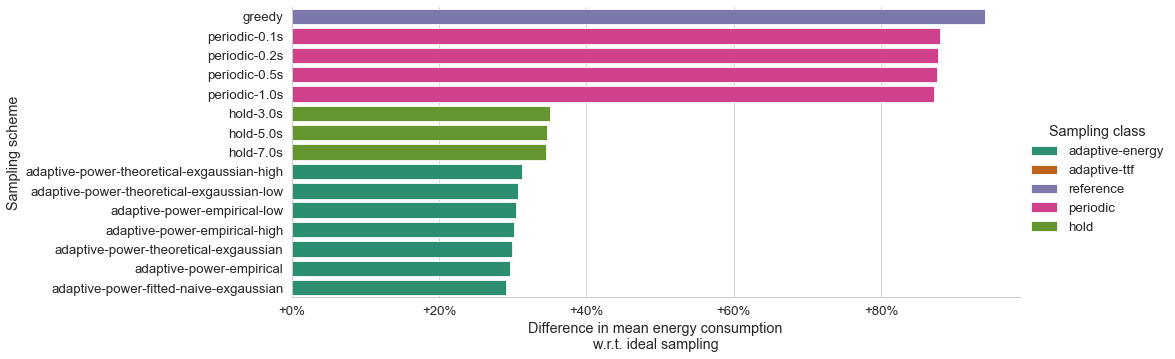

In [21]:
import matplotlib.ticker as tkr

plot_data = energies_maxrtt.reset_index().query("sampling_scheme != 'ideal'")

fg = sns.catplot(
    kind="bar",
    errorbar=None,
    data=plot_data,
    y="sampling_scheme",
    x="mean_diff_ideal_percent",
    aspect=3,
    xerr=plot_data["mean_diff_ideal_95ci_percent"],
    order=plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"],
    hue="sampling_class",
    dodge=False,
)
for ax in fg.axes.flat:
    # pass
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:+0.0%}"))

fg.set_axis_labels("Difference in mean energy consumption\nw.r.t. ideal sampling", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

In [22]:
best_schemes = plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"][-5:]
best_schemes

1              adaptive-power-empirical-low
2             adaptive-power-empirical-high
3     adaptive-power-theoretical-exgaussian
0                  adaptive-power-empirical
6    adaptive-power-fitted-naive-exgaussian
Name: sampling_scheme, dtype: category
Categories (16, object): ['greedy' < 'ideal' < 'adaptive-power-empirical' < 'adaptive-power-empirical-low' ... 'periodic-1.0s' < 'hold-3.0s' < 'hold-5.0s' < 'hold-7.0s']

In [23]:
results_best = results_per_rep[np.isin(results_per_rep["sampling_scheme"], best_schemes)].copy()
results_best["sampling_scheme"] = results_best["sampling_scheme"].cat.remove_unused_categories()
results_best

,timing_model,sampling_scheme,sampling_class,rtt,repetition,execution_time,step_duration,ttf,wait_time,samples,energy,idle_energy,comm_energy,idle_time,comm_time,success_sample_instant
1200,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,1,5.725835,7.111164,1.385330,0.885330,2.925000,0.124217,0.097892,0.026325,6.526164,0.585000,6.611164
1201,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,2,5.813048,7.125077,1.312029,0.812029,2.866667,0.124076,0.098276,0.025800,6.551743,0.573333,6.625077
1202,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,3,5.914865,7.296015,1.381150,0.881150,3.000000,0.127440,0.100440,0.027000,6.696015,0.600000,6.796015
1203,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,4,5.896497,7.130538,1.234041,0.734041,2.933333,0.124558,0.098158,0.026400,6.543871,0.586667,6.630538
1204,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,5,5.930461,7.283721,1.353260,0.853260,2.983333,0.127156,0.100306,0.026850,6.687054,0.596667,6.783721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,56,7.091120,15.908630,8.817510,3.817510,1.216667,0.410179,0.152854,0.257325,10.190296,5.718333,10.908630
5396,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,57,7.879213,16.807241,8.928028,3.928028,1.383333,0.447159,0.154584,0.292575,10.305575,6.501667,11.807241
5397,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,58,7.499521,16.456105,8.956583,3.956583,1.316667,0.432492,0.154017,0.278475,10.267771,6.188333,11.456105
5398,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,59,6.802106,16.003832,9.201726,4.201726,1.233333,0.413957,0.153107,0.260850,10.207165,5.796667,11.003832


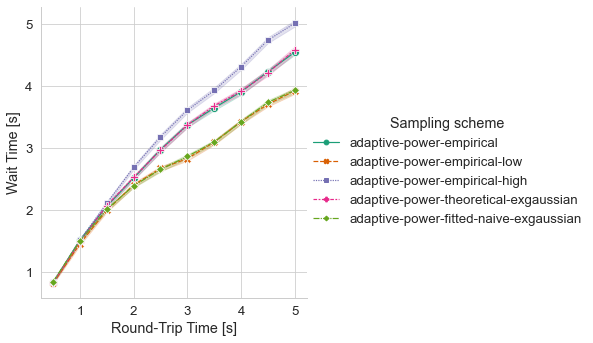

In [24]:
fg = sns.relplot(
    kind="line",
    errorbar=("ci", 95),
    data=results_best,
    x="rtt",
    y="wait_time",
    hue="sampling_scheme",
    style="sampling_scheme",
    markers=True,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Wait Time [s]")
fg.legend.set_title("Sampling scheme")
plt.show()